In [32]:
import mne
import numpy as np
import scipy.signal as signal
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# Load data
df_skill = pd.read_csv(f"./data/filteredData/filtered_data.csv")
df_filtered = df_skill[["Participant", "Algorithm", "SkillScore", "EEG"]]
df_filtered

,Participant,Algorithm,SkillScore,EEG
0,1,IsPrime,0.331385,./data/filteredData/Participant01/IsPrimecode_...
1,1,SiebDesEratosthenes,0.331385,./data/filteredData/Participant01/SiebDesErato...
2,1,IsAnagram,0.331385,./data/filteredData/Participant01/IsAnagramcod...
3,1,RemoveDoubleChar,0.331385,./data/filteredData/Participant01/RemoveDouble...
4,1,BinToDecimal,0.331385,./data/filteredData/Participant01/BinToDecimal...
...,...,...,...,...
1067,71,DumpSorting,0.435651,./data/filteredData/Participant71/DumpSortingc...
1068,71,BinomialCoefficient,0.435651,./data/filteredData/Participant71/BinomialCoef...
1069,71,IsAnagram,0.435651,./data/filteredData/Participant71/IsAnagramcod...
1070,71,ArrayAverage,0.435651,./data/filteredData/Participant71/ArrayAverage...


Opening raw data file ./data/filteredData/Participant01/IsPrimecode_eeg_raw.fif...
    Range : 6629 ... 12819 =     13.258 ...    25.638 secs
Ready.
Reading 0 ... 6190  =      0.000 ...    12.380 secs...
Signal with one channel: (64, 6191)


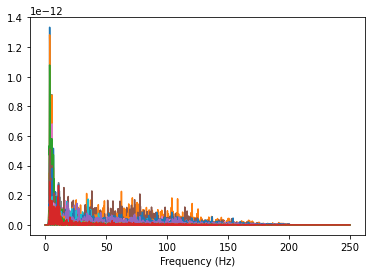

In [33]:
def get_spectrum(data, sampling_rate, method='welch', decibel=False, resolution='auto'):
    """
    Calculate amplitude or power spectrum

    data: Should be of shape (n_channels, n_samples)
    sampling_rate: Sampling rate... (float)
    method:
        * welch for power spectrum using Welch's method (recommended)
        * ft for simple Fourier transform (amplitude spectrum)
        * ps for power spectrum using a simple fourier transform
    decibel: Convert spectrum to decibel (bool)
    """

    axis = -1

    n_channels, n_samples = data.shape

    if resolution == 'auto':
        n_frequencies = n_samples
    elif isinstance(resolution, (int, float)):
        n_frequencies = np.round(sampling_rate / resolution).astype('int')
    else:
        raise ValueError('\'{}\''.format(resolution))

    # Spectrum
    if method in ['ft', 'ps']:
        # Using FFT
        # Get (complex) spectrum
        spec = np.fft.fft(data, n=n_frequencies, axis=axis)
        freq = np.fft.fftfreq(n_frequencies) * sampling_rate

        # Convert to real positive-sided spectrum
        spec = np.abs(spec)
        nyquist = 0.5 * sampling_rate
        is_positive = np.logical_or(np.logical_and(freq >= 0, freq <= nyquist), freq == -nyquist)
        n_pos = np.sum(is_positive)
        is_positive = np.repeat(is_positive[np.newaxis], n_channels, axis=0)
        spec = np.reshape(spec[is_positive], (n_channels, n_pos))
        freq = np.abs(freq[is_positive])
        is_double = np.logical_and(freq > 0, freq < nyquist)
        is_double = np.repeat(is_double[np.newaxis], n_channels, axis=0)
        spec[is_double] = 2 * spec[is_double]

        if method in ['ps']:
            # Get power spectral density
            spec = (1 / (sampling_rate * n_frequencies)) * spec ** 2

            # Convert to decibel if required
            if decibel:
                spec = _to_decibel(spec)
    elif method in ['welch', 'welch_db']:
        # Using Welch method
        freq, spec = signal.welch(data, sampling_rate, nperseg=n_frequencies, detrend='constant', axis=axis)

        # Convert to decibel if required
        if decibel:
            spec = _to_decibel(spec)
    else:
        raise RuntimeError('Unknown method \'{}\''.format(method))

    return spec, freq


def _to_decibel(spec):
    return 10 * np.log10(spec)


sampling_freq = 500.0
first_eeg_file = df_filtered.iloc[0]["EEG"]
eeg_data = mne.io.read_raw_fif(first_eeg_file, preload=True)
eeg_data = eeg_data.get_data()
data_ref = eeg_data - np.mean(eeg_data, axis=0)


print('Signal with one channel:', data_ref.shape)

spec, freq = get_spectrum(data_ref, sampling_freq, method='welch', decibel=False, resolution='auto')

plt.plot(freq, spec.transpose())
plt.xlabel('Frequency (Hz)')
plt.show()